### The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702 entries, 0 to 2701
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             2702 non-null   float64
 1   bath            2702 non-null   float64
 2   acre_lot        2702 non-null   float64
 3   zip_code        2702 non-null   float64
 4   house_size      2702 non-null   float64
 5   prev_sold_date  2702 non-null   object 
 6   price           2702 non-null   float64
dtypes: float64(6), object(1)
memory usage: 147.9+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702 entries, 0 to 2701
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             2702 non-null   float64
 1   bath            2702 non-null   float64
 2   acre_lot        2702 non-null   float64
 3   zip_code        2702 non-null   float64
 4   house_size      2702 non-null   float64
 5   price           2702 non-null   float64
 6   prev_sold_year  2702 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 147.9 KB


#### Find the zip code of that has the most houses.

In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

6010.0

#### Find the rows of the zip code that has the most houses.

In [31]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 112 to 1010
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             46 non-null     float64
 1   bath            46 non-null     float64
 2   acre_lot        46 non-null     float64
 3   zip_code        46 non-null     float64
 4   house_size      46 non-null     float64
 5   price           46 non-null     float64
 6   prev_sold_year  46 non-null     int64  
dtypes: float64(6), int64(1)
memory usage: 2.9 KB


#### Create common variables to store frequently used values.

In [7]:
features = ["bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [8]:
X = one_zipcode_df[features]
y = one_zipcode_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [10]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

#### Use Grid Search CV to find the best Hyperparameters for Lasso Regression

In [30]:
lasso_gscv = GridSearchCV(Lasso(random_state=random_state_value), {'alpha': range(14030,14050,1)})
lasso_gscv_model = lasso_gscv.fit(X, y)
print(f"Best parameters found: {lasso_gscv.best_params_}")

Best parameters found: {'alpha': 490000}


In [12]:
lasso = Lasso(**lasso_gscv.best_params_)
lasso_bp_gscv = GridSearchCV(lasso, param_grid={})
lasso_bp_model = lasso_bp_gscv.fit(X_train,y_train)
lasso_bp_predict = lasso_bp_model.predict(X_test)

print_more_stuff("Lasso Best Params", y_test, lasso_bp_predict, lasso_bp_gscv)

Lasso Best Params EVS = 0.620904155
Lasso Best Params MSE = 6,616,734,080.861444
Lasso Best Params MAE = 61,984.151528
Lasso Best Params R2 = 0.620888
Lasso Best Params Fit Time = 0.0015320301055908204


#### Create common variables that will be used in the Notebook

In [13]:
lasso = Lasso(random_state=random_state_value)
lasso_sfs = SequentialFeatureSelector(estimator=lasso, n_features_to_select=num_features_to_select)
lasso_sfm = SelectFromModel(estimator=lasso, threshold=1000)
lasso_rfe = RFE(estimator=lasso, n_features_to_select=num_features_to_select)

### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [14]:
lasso_sfm_pipeline = Pipeline([
  ('feature_selection', lasso_sfm),
  ('regression', lasso)
])

lasso_sfm_fs = lasso_sfm_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
lasso_sfm_selected_features = lasso_sfm_fs.get_support()

print('The selected features are:', list(X.columns[lasso_sfm_selected_features]))

The selected features are: ['bed', 'bath', 'acre_lot', 'prev_sold_year']


In [15]:
X_sfm = one_zipcode_df[list(X.columns[lasso_sfm_selected_features])]
y_sfm = one_zipcode_df["price"]
X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test = train_test_split(X_sfm, y_sfm, test_size=0.3, random_state=random_state_value)

In [16]:
lasso_sfm_gscv = GridSearchCV(Lasso(), param_grid={})
lasso_sfm_model = lasso_sfm_gscv.fit(X_sfm_train,y_sfm_train)
lasso_sfm_predict = lasso_sfm_model.predict(X_sfm_test)

print_more_stuff("Select From Model",y_sfm_test,lasso_sfm_predict,lasso_sfm_gscv)

Select From Model EVS = 0.497553852
Select From Model MSE = 8,846,968,650.808388
Select From Model MAE = 62,654.563058
Select From Model R2 = 0.493105
Select From Model Fit Time = 0.0015021800994873048


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [17]:
lasso_sfs_pipeline = Pipeline([
  ('feature_selection', lasso_sfs),
  ('regression', lasso)
])

lasso_sfs_fs = lasso_sfs_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
lasso_sfs_selected_features = lasso_sfs_fs.get_support()

print('The selected features are:', list(X.columns[lasso_sfs_selected_features]))

The selected features are: ['bed', 'bath', 'acre_lot', 'house_size']


In [18]:
X_sfs = one_zipcode_df[list(X.columns[lasso_sfs_selected_features])]
y_sfs = one_zipcode_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [19]:
lasso_sfs_gscv = GridSearchCV(Lasso(), param_grid={})
lasso_sfs_model = lasso_sfs_gscv.fit(X_sfs_train,y_sfs_train)
lasso_sfs_predict = lasso_sfs_model.predict(X_sfs_test)

print_more_stuff("Sequential Feature Selector",y_sfs_test,lasso_sfs_predict, lasso_sfs_gscv)

Sequential Feature Selector EVS = 0.708748001
Sequential Feature Selector MSE = 5,084,107,071.349225
Sequential Feature Selector MAE = 53,434.700702
Sequential Feature Selector R2 = 0.708702
Sequential Feature Selector Fit Time = 0.0


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [20]:
lasso_rfe_pipeline = Pipeline([
  ('feature_selection', lasso_rfe),
  ('regression', lasso)
])
lasso_rfe_fs = lasso_rfe_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
lasso_rfe_selected_features = lasso_rfe_fs.get_support()

print('The selected features are:', list(X.columns[lasso_rfe_selected_features]))

The selected features are: ['bed', 'bath', 'acre_lot', 'prev_sold_year']


In [21]:
X_rfe = one_zipcode_df[list(X.columns[lasso_rfe_selected_features])]
y_rfe = one_zipcode_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [22]:
lasso_rfe_gscv = GridSearchCV(Lasso(), param_grid={})
lasso_rfe_model = lasso_rfe_gscv.fit(X_rfe_train,y_rfe_train)
lasso_rfe_predict = lasso_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination",y_rfe_test,lasso_rfe_predict, lasso_rfe_gscv)

Recursive Feature Elimination EVS = 0.497553852
Recursive Feature Elimination MSE = 8,846,968,650.808388
Recursive Feature Elimination MAE = 62,654.563058
Recursive Feature Elimination R2 = 0.493105
Recursive Feature Elimination Fit Time = 0.00047435760498046873


#### Graphing the results works best when the data is provided in a DataFrame.

In [23]:
lasso_bp_predict_df = pd.DataFrame(lasso_bp_predict).reset_index()
lasso_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfm_predict_df = pd.DataFrame(lasso_sfm_predict).reset_index()
lasso_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfs_predict_df = pd.DataFrame(lasso_sfs_predict).reset_index()
lasso_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_rfe_predict_df = pd.DataFrame(lasso_rfe_predict).reset_index()
lasso_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, Select From Model, and Test Data.

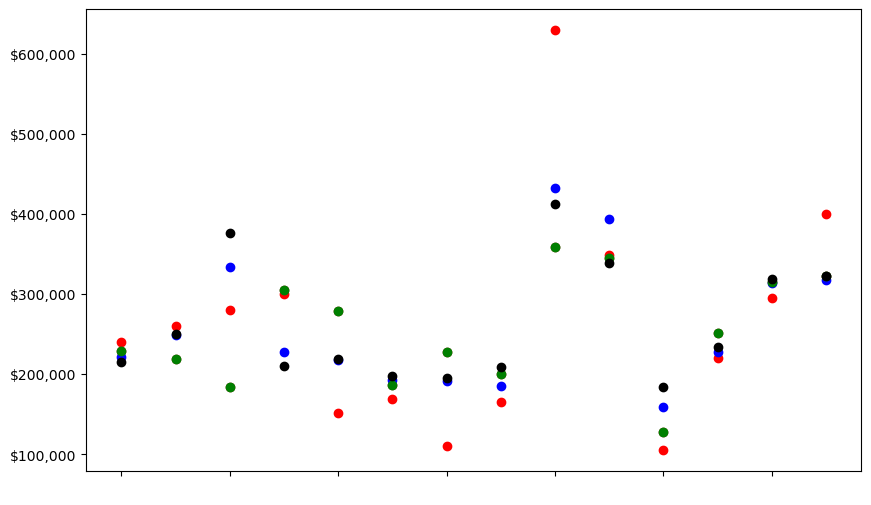

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="brown")
plt.scatter(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="blue")
plt.scatter(lasso_rfe_predict_df.index,lasso_rfe_predict_df["prediction"], color="green")
plt.scatter(lasso_bp_predict_df.index,lasso_bp_predict_df["prediction"], color="black")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [25]:
lasso_bp_predict_df.sort_values(by='prediction', inplace=True)
lasso_bp_predict_df.reset_index(inplace=True)

lasso_sfm_predict_df.sort_values(by='prediction', inplace=True)
lasso_sfm_predict_df.reset_index(inplace=True)

lasso_sfs_predict_df.sort_values(by='prediction', inplace=True)
lasso_sfs_predict_df.reset_index(inplace=True)

lasso_rfe_predict_df.sort_values(by='prediction', inplace=True)
lasso_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Recursive Feature Elimination, Sequential Feature Selection, Select From Model, and Test Data.

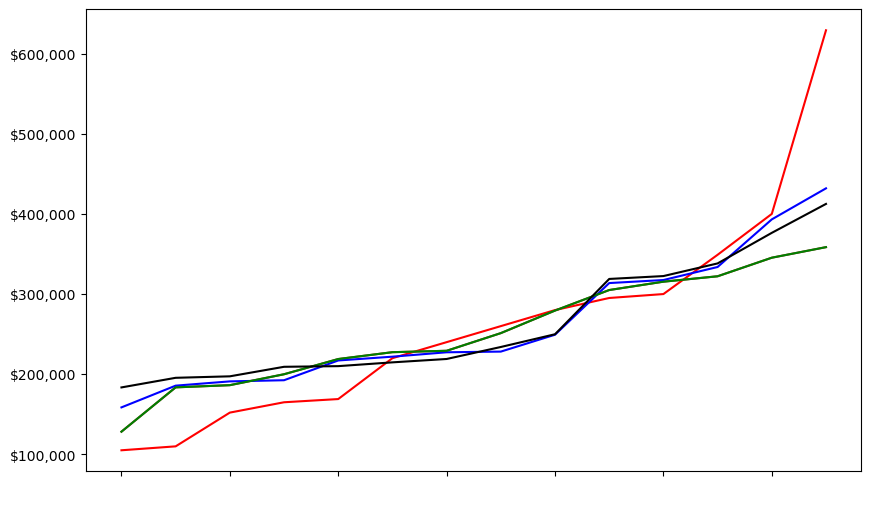

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="brown")
plt.plot(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="blue")
plt.plot(lasso_rfe_predict_df.index,lasso_rfe_predict_df["prediction"], color="green")
plt.plot(lasso_bp_predict_df.index,lasso_bp_predict_df["prediction"], color="black")
plt.show()

In [27]:
results_dict

{'model': ['Lasso Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination'],
 'explained variance score': ['0.620904155',
  '0.497553852',
  '0.708748001',
  '0.497553852'],
 'mae score': ['61,984.151528',
  '62,654.563058',
  '53,434.700702',
  '62,654.563058'],
 'mse score': ['6,616,734,080.861444',
  '8,846,968,650.808388',
  '5,084,107,071.349225',
  '8,846,968,650.808388'],
 'r2 score': ['0.620888', '0.493105', '0.708702', '0.493105'],
 'mean fit time': [0.0015320301055908204,
  0.0015021800994873048,
  0.0,
  0.00047435760498046873]}

In [28]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Lasso Best Params,0.620904155,"61,984.151528","6,616,734,080.861444",0.620888,0.001532
Select From Model,0.497553852,"62,654.563058","8,846,968,650.808388",0.493105,0.001502
Sequential Feature Selector,0.708748001,"53,434.700702","5,084,107,071.349225",0.708702,0.000000
Recursive Feature Elimination,0.497553852,"62,654.563058","8,846,968,650.808388",0.493105,0.000474
